# Discriminating volcanic rock samples' tectonic settings using machine learning

A take at making classification diagrams better.

In [1]:
import sys
import getpass
print("User :", getpass.getuser())
print("Python version :", sys.version)
%load_ext watermark
%watermark -i -v -m -p pandas,numpy,matplotlib,sklearn

User : CloudyOverhead
Python version : 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
2017-08-01T09:31:00-04:00

CPython 3.6.1
IPython 5.3.0

pandas 0.20.2
numpy 1.12.1
matplotlib 2.0.2
sklearn 0.18.2

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.10.0-514.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 32
interpreter: 64bit


In [2]:
%matplotlib inline

import time
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import random as rd
import numpy as np
import os
import re

from itertools import count, cycle, combinations

from scipy.stats.mstats import gmean

from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (f1_score, make_scorer, confusion_matrix, mean_absolute_error, 
                             median_absolute_error, mean_squared_error)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeavePGroupsOut, cross_val_predict

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

## Concatenate Georoc database

### Concatenation

Concatenation of the *.csv* files contained in */Georoc_files* into a single *master.csv* file at source.

In [37]:
# Files from /Georoc_files are opened one by one and stored as DataFrames in the *files* list.

dir_ = os.curdir + '/Georoc_files'
files = os.listdir(dir_)

nb_data = 0

for file, file_no in zip(files, count()):

    file = pd.read_csv(dir_ + '/' + file, encoding='iso-8859-1', dtype=object)

    index = np.where(file.CITATIONS.values == 'References:')[0][0]
    file = file[:index]
    file.insert(0, 'FILENAME', files[file_no])

    nb_data += file.shape[0]
    files[file_no] = file

In [38]:
# Files are regrouped in *master_file*. *nb_data* was needed because of the *.append* method being resources-expensive.

master_file = pd.DataFrame(index=np.arange(0, nb_data), columns=files[0].axes[1])
current_row = 0

row_no = 0
for file in files:
    for _, row in file.iterrows():
        master_file.loc[row_no] = row
        row_no += 1

del files, file

In [39]:
# Non-volcanic rocks, duplicates and unnecessary columns are removed.
master_file = master_file[master_file['ROCK TYPE'] == 'VOLCANIC ROCK']
master_file.drop_duplicates(subset='UNIQUE_ID', inplace=True)
master_file.drop('Unnamed: 171', axis=1, inplace=True)

# Empty columns are deleted.
a = master_file.iloc[:, 28:-1].count(axis=0)
for index, value in a.iteritems():
    if value < 1000:
        master_file.drop(index, axis=1, inplace=True)

# Tectonics settings are formatted identically.
master_file['TECTONIC SETTING'] = master_file['TECTONIC SETTING'].str.upper()

# *SEAMOUNT* and *SUBMARINE RIDGE* tectonic settings are removed, as those are topography types and not formation processes,
# and thus geochemistry can provide no informative insight. *COMPLEX VOLCANIC SETTINGS* is removed as this tectonic setting
# is an amalgam of settings.
master_file = master_file[~ master_file['TECTONIC SETTING'].isin(['SEAMOUNT', 'SUBMARINE RIDGE', 'COMPLEX VOLCANIC SETTINGS'])]

# *OCEAN PLATEAU*, *CONTINENTAL FLOOD BASALT* and *OCEAN-BASIN FLOOD BASALT* tectonic settings are regrouped under the label
# *FLOOD BASALT*, as their formation processes are the same.
master_file = master_file.replace(['OCEANIC PLATEAU', 'CONTINENTAL FLOOD BASALT', 'OCEAN-BASIN FLOOD BASALT'], 'FLOOD BASALT')

# *ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)* is formatted into *ARCHEAN CRATON* for convenience.
master_file = master_file.replace('ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)', 'ARCHEAN CRATON')

# Removing data messes with the indexing
master_file = master_file.reset_index(drop=True)

In [40]:
# Data under limit of detection is formatted to half the limit of detection.

for row_no, row in master_file.iloc[:, 28:171].iterrows():
    for col_no, data in zip(count(), row):
        data = str(data).strip()

        if data[0] == '-':  # Data under limit of detection has format *-data*. *<data* is not used
            master_file.iloc[row_no, col_no + 28] = -float(data) / 2

#         elif data[0] == '<':
#             print(master_file.iloc[row_no, col_no + 28])
#             master_file.iloc[row_no, col_no + 28] = float(data.lstrip(['<', '='])) / 2
#             print(master_file.iloc[row_no, col_no + 28])
#         else:
#             data = float(data)  # failsafe

In [41]:
# WT% are converted to PPM, leaving only PPM units.

for index, column in enumerate(master_file.axes[1].tolist()[28:-1]):

    if column[-5:] == '(WT%)':

        master_file[column] = master_file[column].astype(float).apply(lambda x: x * 10**4)

master_file.columns = [col.replace('(WT%)', '').replace('(PPM)', '') for col in master_file.axes[1].tolist()]

In [42]:
# Data is saved in *master.csv* at source, allowing it to be reloaded for future uses.

master_file.to_csv(os.curdir + '/master.csv', index=False)

### Load master

In [3]:
# Should be used on reloads to produce faster results.

master_file = pd.read_csv(os.curdir + '/master.csv', encoding='iso-8859-1', dtype=object)

### Statistics

In [4]:
print ('Shape of the dataset after transformation:' + str(master_file.shape))
master_file.head()

Shape of the dataset after transformation:(263526, 126)


,FILENAME,CITATIONS,TECTONIC SETTING,LOCATION,LOCATION COMMENT,LATITUDE MIN,LATITUDE MAX,LONGITUDE MIN,LONGITUDE MAX,LAND OR SEA,ELEVATION MIN,ELEVATION MAX,SAMPLE NAME,ROCK NAME,MIN. AGE (YRS.),MAX. AGE (YRS.),GEOL.,AGE,ERUPTION DAY,ERUPTION MONTH,ERUPTION YEAR,ROCK TEXTURE,ROCK TYPE,DRILL DEPTH MIN,DRILL DEPTHAX,ALTERATION,MINERAL,MATERIAL,SIO2,TIO2,AL2O3,CR2O3,FE2O3,FEO,FEOT,CAO,MGO,MNO,NIO,K2O,NA2O,P2O5,H2O,H2OP,H2OM,CO2,F,CL,SO3,S,LOI,LI,BE,B,F.1,P,S.1,CL.1,K,SC,TI,V,CR,MN,CO,NI,CU,ZN,GA,GE,AS,SE,RB,SR,Y,ZR,NB,MO,RU,RH,PD,AG,CD,IN,SN,SB,CS,BA,LA,CE,PR,ND,SM,EU,GD,TB,DY,HO,ER,TM,YB,LU,HF,TA,W,RE,OS,IR,PT,AU,TL,PB,BI,TH,U,ND143_ND144,SR87_SR86,SR87_SR86_INI,PB206_PB204,PB207_PB204,PB208_PB204,OS187_OS188,RE187_OS188,HF176_HF177,HE3_HE4(R/R(A)),UNIQUE_ID
0,ALPS_SARDINIA_CORSICA_PALEOZOIC.csv,[19915],INTRAPLATE VOLCANICS,ALPS_SARDINIA_CORSICA_PALEOZOIC / SOUTHERN ALP...,SOUTHERN INTRA-CALDERA,46.5,46.7,11.15,11.35,SUBAERIAL,NaN,NaN,s SIC [19915],RHYOLITE [19915],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [19915],741200.0,2900.0,136000.0,NaN,NaN,NaN,21100.0,6000.0,7800.0,800.0,NaN,45900.0,35100.0,700.0000000000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,NaN,20.4,6.67,NaN,4.43,4.78,NaN,44.7,NaN,NaN,NaN,NaN,224.1,91.4,34.9,193.9,12.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322.7,26.8,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,21.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1014271
1,ALPS_SARDINIA_CORSICA_PALEOZOIC.csv,[19915],INTRAPLATE VOLCANICS,ALPS_SARDINIA_CORSICA_PALEOZOIC / SOUTHERN ALP...,NORTHERN INTRA-CALDERA,46.5,46.7,11.15,11.35,SUBAERIAL,NaN,NaN,s NIC [19915],RHYOLITE [19915],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [19915],748400.0,2300.0,140600.0,NaN,NaN,NaN,14800.0,6899.999999999999,3800.0,700.0000000000001,NaN,59000.0,21400.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.7,NaN,13.83,5.8,NaN,4,4.08,NaN,35,NaN,NaN,NaN,NaN,259.96,59.23,46.11,194.48,12.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413.22,36.85,74.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.48,NaN,20.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1014272
2,ALPS_SARDINIA_CORSICA_PALEOZOIC.csv,[19915],INTRAPLATE VOLCANICS,ALPS_SARDINIA_CORSICA_PALEOZOIC / SOUTHERN ALP...,NORTHERN EXTRA-CALDERA,46.5,46.7,11.15,11.35,SUBAERIAL,NaN,NaN,s NEC [19915],RHYOLITE [19915],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [19915],767300.0,1000.0,133500.0,NaN,NaN,NaN,12700.0,3800.0,2500.0,600.0,NaN,57100.0,19900.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.22,NaN,NaN,NaN,NaN,NaN,4.5,NaN,32.44,NaN,NaN,NaN,NaN,283.78,23.8,53.78,110.33,14.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.11,23.33,51.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.6,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1014273
3,ALPS_SARDINIA_CORSICA_PALEOZOIC.csv,[19915],INTRAPLATE VOLCANICS,ALPS_SARDINIA_CORSICA_PALEOZOIC / SOUTHERN ALP...,SOUTHERN INTRA-CALDERA,46.5,46.7,11.15,11.35,SUBAERIAL,NaN,NaN,s 14 LOWER [19915],RHYOLITE [19915],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [19915],NaN,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.9,149.9,10.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.2,60.7,4.5,17.5,3.9,0.4,3.7,0.6,3.9,0.8,2.4,0.4,2.7,0.4,4.3,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.7,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1014274
4,ALPS_SARDINIA_CORSICA_PALEOZOIC.csv,[19915],INTRAPLATE VOLCANICS,ALPS_SARDINIA_CORSICA_PALEOZOIC / SOUTHERN ALP...,SOUTHERN INTRA-CALDERA,46.5,46.7,11.15,11.35,SUBAERIAL,NaN,NaN,s 14 UPPER [19915],RHYOLITE [19915],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLCANIC

In [5]:
# Column names

pd.Series(master_file.axes[1])

0              FILENAME
1             CITATIONS
2      TECTONIC SETTING
3              LOCATION
4      LOCATION COMMENT
5          LATITUDE MIN
6          LATITUDE MAX
7         LONGITUDE MIN
8         LONGITUDE MAX
9           LAND OR SEA
10        ELEVATION MIN
11        ELEVATION MAX
12          SAMPLE NAME
13            ROCK NAME
14      MIN. AGE (YRS.)
15      MAX. AGE (YRS.)
16                GEOL.
17                  AGE
18         ERUPTION DAY
19       ERUPTION MONTH
20        ERUPTION YEAR
21         ROCK TEXTURE
22            ROCK TYPE
23      DRILL DEPTH MIN
24        DRILL DEPTHAX
25           ALTERATION
26              MINERAL
27             MATERIAL
28                 SIO2
29                 TIO2
30                AL2O3
31                CR2O3
32                FE2O3
33                  FEO
34                 FEOT
35                  CAO
36                  MGO
37                  MNO
38                  NIO
39                  K2O
40                 NA2O
41              

In [6]:
# Samples contained per file

master_file['FILENAME'].value_counts()

ICELAND.csv                                              9163
HAWAIIAN_ISLANDS_1.csv                                   8058
HONSHU_ARC_1.csv                                         7657
YELLOWSTONE-SNAKE_RIVER_PLAIN_VOLCANIC_PROVINCE.csv      7093
ANATOLIA-IRAN_BELT_-_CENOZOIC_QUATERNARY.csv             6572
ANDEAN_ARC_1.csv                                         6412
ANDEAN_ARC_2.csv                                         6303
EAST_AFRICAN_RIFT.csv                                    6183
IZU-BONIN_ARC.csv                                        5658
APENNINIC-MAGHREBIDES_CHAIN_1.csv                        5418
HONSHU_ARC_2.csv                                         5375
APENNINIC-MAGHREBIDES_CHAIN.csv                          5170
CENTRAL_ASIAN_FOLDBELT_-_CENOZOIC_QUATERNARY_2.csv       5119
MEXICAN_VOLCANIC_BELTS.csv                               5069
BASIN_AND_RANGE_-_GREAT_BASIN.csv                        4925
NORTH_ATLANTIC_IGNEOUS_PROVINCE_OR_NAIP.csv              4621
NEW_ZEAL

In [7]:
# Samples obtained per rock name

temp = master_file['ROCK NAME'].value_counts()
filter_ = r'\[(\d)*\]'

# Citations are removed from the index so that identical rock names have identical indexes.
temp.index = temp.index.astype(str).str.replace(filter_, '').str.strip().str.replace('  ', ' ')

# Samples with identical rock names are regrouped
temp = temp.groupby(temp.index).sum().sort_values(ascending=False)
print(temp)

NOT GIVEN                                                                    52853
BASALT                                                                       51809
ANDESITE                                                                     19243
RHYOLITE                                                                     17189
THOLEIITE                                                                    11461
ANDESITE, BASALTIC                                                           10745
DACITE                                                                        9912
BASALT, ALKALINE                                                              6757
TRACHYTE                                                                      4952
BASANITE                                                                      4623
KIMBERLITE                                                                    4437
KOMATIITE                                                                     3492
BASA

In [8]:
# Samples obtained per tectonic setting

master_file['TECTONIC SETTING'].value_counts()

CONVERGENT MARGIN       96893
INTRAPLATE VOLCANICS    56862
OCEAN ISLAND            41105
FLOOD BASALT            35321
RIFT VOLCANICS          19080
ARCHEAN CRATON          14265
Name: TECTONIC SETTING, dtype: int64

### QA/QC

Elements columns that doesn't contain enough data are dropped. Next, samples with missing observations in the remaining columns are dropped.

In [9]:
# Number of missing observations per element.

a = master_file.iloc[:, 28:-1].count(axis=0)
a = len(master_file.index) - a

In [10]:
# Elements with quantity of missing observations over *value* are dropped, with the exception of elements 
# in *index_keep*, and with the addition of elements in *index_drop*.

# PARAMETERS #
value = 110000  # Deletion threshold  (52: 152000) (41: 110000 (Important ones))
index_drop = []  # ['MNO', 'ND', 'RB']  # Deleted elements
index_keep = ['TA', 'HF', 'SC', 'TH', 'CE', 'ZR', 'NB', 'Y']  # Preserved elements
##############

index_ = (a > value) & ~ a.index.isin(index_keep) | a.index.isin(index_drop)

In [11]:
# A file with deleted data is created. The original is unaltered.

filtered_file = master_file.copy();

# Removes columns with too much missing data
filtered_file.drop(a[index_].index.values, axis=1, inplace=True)

# Removes samples with missing data
filtered_file.dropna(subset=a[~ index_].index.values, inplace=True)

filtered_file = filtered_file.reset_index(drop=True)  # Removing data messes with the indexing

In [12]:
print('Shape of the dataset after transformation:', str(filtered_file.shape), 'Out of:', str(master_file.shape), '\n')
print(filtered_file.iloc[:, 28:-1].axes[1], '\n')
print(filtered_file['TECTONIC SETTING'].value_counts())

Shape of the dataset after transformation: (47715, 49) Out of: (263526, 126) 

Index(['SIO2', 'TIO2', 'AL2O3', 'CAO', 'MGO', 'MNO', 'K2O', 'NA2O', 'P2O5',
       'SC', 'RB', 'SR', 'Y', 'ZR', 'NB', 'BA', 'CE', 'HF', 'TA', 'TH'],
      dtype='object') 

INTRAPLATE VOLCANICS    17241
CONVERGENT MARGIN       12883
FLOOD BASALT             7119
OCEAN ISLAND             4407
ARCHEAN CRATON           3100
RIFT VOLCANICS           2965
Name: TECTONIC SETTING, dtype: int64


## Analysis

In [75]:
# Utility functions and classes

f1_scorer = make_scorer(f1_score, average='weighted')


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

    
def file_split_gen(file, n_out=1, n_splits=1, seed=None):

    if n_out * n_splits > len(file.unique()):
        raise IndexError

    if seed is not None:
        rd.seed(seed)

    groups = list(file.unique())
    rd.shuffle(groups)
    current = 0

    for _ in range(n_splits):
        train_set = file.copy()
        test_set = file.copy()

        group = groups[current:current + n_out]
        train_set = train_set[~ train_set.isin(group)]
        test_set = test_set[test_set.isin(group)]
        current += n_out

        yield train_set.index, test_set.index


def to_int(x):
    return x.replace({'ARCHEAN CRATON': 0,
                      'CONVERGENT MARGIN': 1,
                      'FLOOD BASALT': 2,
                      'INTRAPLATE VOLCANICS': 3,
                      'OCEAN ISLAND': 4,
                      'RIFT VOLCANICS': 5})


def make_CLR(dataframe):
    temp_df = pd.DataFrame(index=dataframe.axes[0], columns=dataframe.axes[1])
    for index, Series in dataframe.iterrows():
        if index % 1000 == 0:
            print(index)
        Series = Series.apply(lambda x: x / Series.apply(lambda y: (y - x)**2).sum())
        temp_df.iloc[index] = Series
    return temp_df


def do_grid_search(classifier, parameters, file_splitting, n_out=20, n_splits=2, seed=43, verbose=True):
    pipeline = make_pipeline(StandardScaler(), classifier)
    # print(pipeline.get_params().keys())

    if verbose:
        start = datetime.datetime.now()
        print("Start time :", start)
        verbose_ = 2
    else:
        verbose_ = 0

    # Regular grid search.
    if file_splitting: # Grid search using file splitting.
        cv = file_split_gen(filenames_train, n_out=n_out, n_splits=n_splits, seed=seed)
        grid = GridSearchCV(pipeline, parameters, cv=cv, scoring=f1_scorer, n_jobs=-1, verbose=verbose_)
    else:
        grid = GridSearchCV(pipeline, parameters, cv=2, scoring=f1_scorer, n_jobs=-1, verbose=verbose_)

    # Data fitting.
    clf = grid.fit(X_train, y_train)  # Will take quite some time. View the progress on the console.

    if verbose:
        end = datetime.datetime.now()
        print("Start time:", end)
        print("Time elapsed:", end - start, '\n')

        print("Best parameters set found on development set:")
        print(clf.cv_results_['params'][clf.best_index_])
        print("Score: %0.03f" % clf.best_score_)

    return clf


def do_visualize_score(clf, range_x, range_y, label_x='', label_y='', vmin=0.4, midpoint=0.83):
    scores = clf.cv_results_['mean_test_score'].reshape((len(range_y), len(range_x)))
    print("Mean scores:", '\n', scores)

    stddev = clf.cv_results_['std_test_score'].reshape((len(range_y), len(range_x)))
    print("Standard deviation:", '\n', stddev)

    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=0.3, right=0.8, bottom=0.3, top=0.8)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=vmin, midpoint=midpoint))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar()
    plt.xticks(np.arange(len(range_x)), range_x, rotation=45)
    plt.yticks(np.arange(len(range_y)), range_y)
    plt.title('Validation accuracy')
    plt.show()


def do_validation(classifier, verbose=True):
    # Estimating success scores on test data.
    pipeline = make_pipeline(StandardScaler(), classifier)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='weighted')

    if verbose:
        # Viewing validation results
        print('f1:', str(f1))
        print('Train data:', y_train.shape[0], 'Test data:', y_test.shape[0])

        conf = confusion_matrix(y_test, y_pred)
        print_confusion_matrix(conf)

    else:
        return f1


def print_confusion_matrix(conf):
    conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]  # Normalizes
    plt.imshow(conf, interpolation='nearest', cmap=plt.cm.gray, norm=Normalize(1, 0))
    plt.xlabel('Predicted')
    plt.ylabel('Data')
    plt.colorbar()
    labels = sorted(y_test.unique())
    range_ = np.arange(len(labels))
    plt.xticks(range_, labels, rotation=90)
    plt.yticks(range_, labels)
    plt.title('Validation accuracy')
    plt.show()


def do_adjust_TIO2(series):
    pass  # SINCLAS, Dialnet p. 26


def do_to_DF_coords(dataframe, c_1, c_2):  # c_ -> coefficients_: tuple of length 5
    """
    Formats data into coordinates for a single graph from [1].
    """
    coords = pd.Series(index=np.arange(0, dataframe.shape[0]))

    assert (len(coefs_1) == 5 and len(coefs_2) == 5)

    for index, series in dataframe.iterrow():
        adjusted_TIO2 = do_adjust_TIO2(series)
        series = series.apply(lambda x: np.log(x / adjusted_TIO2))
        x = c_1[0] * series['NB'] + c_1[1] * series['V'] + c_1[2] * series['Y'] + c_1[3] * series['ZR'] + c_1[4]
        y = c_2[0] * series['NB'] + c_2[1] * series['V'] + c_2[2] * series['Y'] + c_2[3] * series['ZR'] + c_2[4]
        coords[index] = (x, y)

    return coords


def do_DF_classification(DF, center, A, B, C):  # A, B, C have formats {0: x, 1: y, 's': (setting_1, setting_2)}
    """
    Classifies data in DF according to the center and outer points from the corresponding graph of [1].
    Tectonic settings the lines split should be specified in ['s'].
    """
    classification = pd.Series(index=np.arange(0, DF.shape[0]))
    quadrants = [None, None, None, None] # Refers to each of the 4 quadrants of the graph, centered on the intersection, and
                                         # organized as: [[0, 1]
                                         #                [2, 3]]

    for pt in (A, B, C):
        index = 0
        if pt[0] > center[0]:
            index += 1
        if pt[1] < center[1]:
            index += 2
        quadrants[index] = pt

    neighbors = {0:(1, 2), 1:(0, 3), 2:(3, 0), 3:(2, 1)}  # Neighbors of each quadrant

    for pos, splitter in enumerate(quadrants):
        if splitter is None:
            for setting in quadrants[neighbors[pos][0]]['s']:
                if setting in quadrants[neighbors[pos][1]]['s']:
                    # Empty quadrant is filled with a dummy point.
                    quadrants[pos] = {0:0, 1:0, 's':(setting,) * 2}

    for pos, splitter in enumerate(quadrants):
        if splitter['s'][0] in quadrants[neighbors[pos][0]]['s']:
            # Tectonic settings are reorganized correctly.
            quadrants[pos]['s'] = quadrants[pos]['s'][::-1]

    quadrants[1]['s'] = quadrants[1]['s'][::-1]
    quadrants[3]['s'] = quadrants[3]['s'][::-1]

    # At this point, tectonic settings to the left of the line should be in position 0 of the tuple, and vice versa.

    # print([i['s'] for i in quadrants])

    for pos, pt in enumerate(quadrants):
        # Linear equations x(y) for each of the lines are computed.
        quadrants[pos]['e'] = lambda y: (y - center[1]) * (pt[0] - center[0]) / (pt[1] - center[1]) + center[0]

    for i, coords in DF.iteritems():

        # Determines in which quadrant the point is in order to select the right equation.
        index = 0
        if coords[0] > center[0]:
            index += 1
        if coords[1] < center[1]:
            index += 2

        # Classifies the point accordingly.
        if quadrants[index]['e'](coords[1]) < coords[0]:
            classification[i] = quadrants[index]['s'][0]
        else:  # If equal, will choose the setting to the right
            classification[i] = quadrants[index]['s'][1]

    return classification


def dry_basis(dataframe):  # Accepts a whole dataframe, slices it accordingly and returns the normalized sliced dataframe.
    dataframe = dataframe.loc[:, 'SIO2':'P2O5'].astype(np.float32)
    total = dataframe.sum(axis=1)

    for i, series in dataframe.iterrows():
        series = series.apply(lambda x: x * 1000000 / total[i])
        dataframe.iloc[i] = series

    return dataframe

In [76]:
dry_basis(master_file).head()

,SIO2,TIO2,AL2O3,CR2O3,FE2O3,FEO,FEOT,CAO,MGO,MNO,NIO,K2O,NA2O,P2O5
0,743057.6250,2907.268066,136340.859375,NaN,NaN,NaN,21152.882812,6015.037598,7819.548828,802.005005,NaN,46015.039062,35187.968750,701.754395
1,749674.4375,2303.916748,140839.421875,NaN,NaN,NaN,14825.203125,6911.750000,3806.470947,701.192017,NaN,59100.472656,21436.441406,400.681152
2,768452.6875,1001.502258,133700.546875,NaN,NaN,NaN,12719.079102,3805.708496,2503.755615,600.901367,NaN,57185.777344,19929.894531,100.150223
3,NaN,1000000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1000000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Lazy creation of training and testing sets:

In [14]:
X = filtered_file.iloc[:, 28:-1].astype(float)
y = filtered_file['TECTONIC SETTING']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, random_state=42)

##### Custom creation of training and testing sets:
Allows splitting data by filenames.

In [15]:
# Reinitializes the generator.

generator = file_split_gen(filtered_file['FILENAME'], n_out=30, n_splits=4, seed=42)

In [16]:
# Splits the data. Run this cell again to progress through the splits.

train_ind, test_ind = next(generator)
X = filtered_file.iloc[:, 28:-1].astype(float)
y = filtered_file['TECTONIC SETTING']

X_train, X_test = X.iloc[train_ind].reset_index(drop=True), X.iloc[test_ind].reset_index(drop=True)
y_train, y_test = y.iloc[train_ind].reset_index(drop=True), y.iloc[test_ind].reset_index(drop=True)
filenames_train = filtered_file['FILENAME'].iloc[train_ind].reset_index(drop=True)

count_ = y_test.value_counts()
print(count_, '\n')
print(len(count_), 'settings out of 6.')
print("Test data:", y_test.shape[0], "Out of:", filtered_file.shape[0])
print(len(filtered_file['FILENAME'][test_ind].value_counts()), 'test files out of', len(filtered_file['FILENAME'].value_counts()))

INTRAPLATE VOLCANICS    4421
CONVERGENT MARGIN       2118
FLOOD BASALT             912
RIFT VOLCANICS            76
ARCHEAN CRATON            38
OCEAN ISLAND              16
Name: TECTONIC SETTING, dtype: int64 

6 settings out of 6.
Test data: 7581 Out of: 47715
30 test files out of 226


### 1) SVM

In [81]:
C_range = 10.0 ** (np.arange(1, 4))
gamma_range= 10.0 ** (np.arange(-3, 0))
param_grid = dict(svc__C=C_range, svc__gamma=gamma_range)

clf = do_grid_search(SVC(cache_size=2000, class_weight='balanced'), param_grid, True)

Start time : 2017-07-25 10:53:23.075978
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] svc__C=10.0, svc__gamma=0.001 ...................................
[CV] svc__C=10.0, svc__gamma=0.001 ...................................
[CV] svc__C=10.0, svc__gamma=0.01 ....................................
[CV] svc__C=10.0, svc__gamma=0.01 ....................................
[CV] svc__C=10.0, svc__gamma=0.1 .....................................
[CV] svc__C=10.0, svc__gamma=0.1 .....................................
[CV] svc__C=100.0, svc__gamma=0.001 ..................................
[CV] svc__C=100.0, svc__gamma=0.001 ..................................
[CV] svc__C=100.0, svc__gamma=0.01 ...................................
[CV] svc__C=100.0, svc__gamma=0.01 ...................................
[CV] svc__C=100.0, svc__gamma=0.1 ....................................
[CV] svc__C=100.0, svc__gamma=0.1 ....................................
[CV] svc__C=1000.0, svc__gamma=0.001 ...........

/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/sit

[CV] ...................... svc__C=10.0, svc__gamma=0.1, total= 1.1min
[CV] ...................... svc__C=10.0, svc__gamma=0.1, total= 1.1min


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..................... svc__C=100.0, svc__gamma=0.1, total= 1.4min
[CV] ..................... svc__C=100.0, svc__gamma=0.1, total= 1.4min


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..................... svc__C=10.0, svc__gamma=0.01, total= 1.3min


[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:  2.1min remaining:  5.6min


[CV] .................... svc__C=100.0, svc__gamma=0.01, total= 1.4min
[CV] ..................... svc__C=10.0, svc__gamma=0.01, total= 1.4min
[CV] .................... svc__C=100.0, svc__gamma=0.01, total= 1.5min


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ................... svc__C=100.0, svc__gamma=0.001, total= 1.6min
[CV] ................... svc__C=100.0, svc__gamma=0.001, total= 1.7min


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] .................... svc__C=10.0, svc__gamma=0.001, total= 1.8min
[CV] .................... svc__C=10.0, svc__gamma=0.001, total= 1.8min
[CV] .................. svc__C=1000.0, svc__gamma=0.001, total= 2.0min
[CV] .................. svc__C=1000.0, svc__gamma=0.001, total= 2.0min


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ................... svc__C=1000.0, svc__gamma=0.01, total= 2.4min


[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  3.1min remaining:   36.8s


[CV] ................... svc__C=1000.0, svc__gamma=0.01, total= 2.5min
[CV] .................... svc__C=1000.0, svc__gamma=0.1, total= 2.7min
[CV] .................... svc__C=1000.0, svc__gamma=0.1, total= 2.9min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.4min finished


Start time: 2017-07-25 10:58:17.819453
Time elapsed: 0:04:54.743475 

Best parameters set found on development set:
{'svc__C': 100.0, 'svc__gamma': 0.01}
Score: 0.398


Mean scores: 
 [[ 0.38044451  0.39623428  0.39408699]
 [ 0.39397007  0.3982029   0.3913141 ]
 [ 0.39572079  0.39203481  0.37319255]]
Standard deviation: 
 [[ 0.09384678  0.07225311  0.03224043]
 [ 0.08117955  0.06095616  0.01341036]
 [ 0.07691411  0.04272331  0.03967854]]


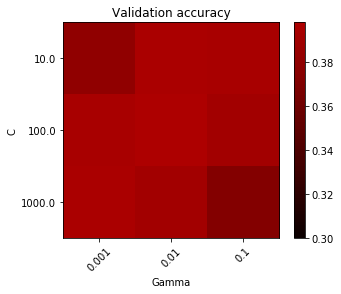

In [82]:
do_visualize_score(clf, gamma_range, C_range, 'Gamma', 'C', vmin=0.3, midpoint=0.5)

f1: 0.64833883841
Train data: 40332 Test data: 6358


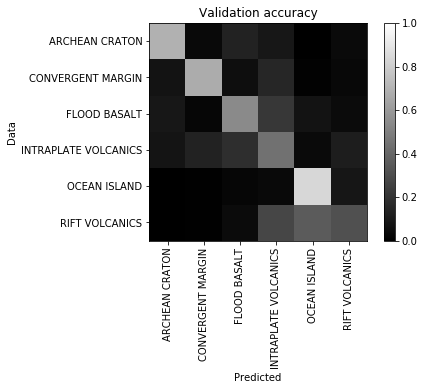

In [83]:
best_C     = 10 ** (2)
best_gamma = 10 ** (-2)

do_validation(SVC(C=best_C, gamma=best_gamma, cache_size=2000, class_weight='balanced'))

### 2) Nearest Neighbors

In [77]:
neighbors_range = np.arange(2, 8)
weights = ['uniform', 'distance']
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range, kneighborsclassifier__weights=weights)

clf = do_grid_search(KNeighborsClassifier(), param_grid, True)

Start time : 2017-07-25 10:51:45.649544
Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=uniform 
[CV] kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=uniform 
[CV] kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=distance 
[CV] kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=distance 
[CV] kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform 
[CV] kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform 
[CV] kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance 
[CV] kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance 
[CV] kneighborsclassifier__n_neighbors=4, kneighborsclassifier__weights=uniform 
[CV] kneighborsclassifier__n_neighbors=4, kneighborsclassifier__weights=uniform 
[CV] kneighborsclassifier__n_neighbors=4, kneighborsclassifier__weights=distance 
[CV

/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/sit

[CV]  kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=distance, total=   1.5s
[CV]  kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=uniform, total=   1.6s
[CV]  kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=uniform, total=   1.8s
[CV]  kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=distance, total=   2.0s
[CV]  kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform, total=   1.8s
[CV]  kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance, total=   1.8s
[CV]  kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform, total=   2.3s
[CV]  kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance, total=   2.3s
[CV]  kneighborsclassifier__n_neighbors=4, kneighborsclassifier__weights=uniform, total=   2.1s
[CV]  kneighborsclassifier__n_neighbors=4, kneighborsclassifier__weights=distance, total=   1.9s
[CV]  kneighborsclassifier__n_neigh

[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:   21.9s remaining:   18.6s


[CV]  kneighborsclassifier__n_neighbors=6, kneighborsclassifier__weights=distance, total=   2.0s
[CV]  kneighborsclassifier__n_neighbors=6, kneighborsclassifier__weights=distance, total=   2.5s
[CV]  kneighborsclassifier__n_neighbors=4, kneighborsclassifier__weights=distance, total=   2.4s
[CV]  kneighborsclassifier__n_neighbors=5, kneighborsclassifier__weights=distance, total=   2.7s
[CV]  kneighborsclassifier__n_neighbors=7, kneighborsclassifier__weights=uniform, total=   1.3s
[CV]  kneighborsclassifier__n_neighbors=6, kneighborsclassifier__weights=uniform, total=   2.7s
[CV]  kneighborsclassifier__n_neighbors=7, kneighborsclassifier__weights=distance, total=   2.0s
[CV]  kneighborsclassifier__n_neighbors=5, kneighborsclassifier__weights=uniform, total=   2.8s
[CV]  kneighborsclassifier__n_neighbors=7, kneighborsclassifier__weights=uniform, total=   2.9s
[CV]  kneighborsclassifier__n_neighbors=7, kneighborsclassifier__weights=distance, total=   2.1s


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   24.4s finished


Start time: 2017-07-25 10:52:11.889168
Time elapsed: 0:00:26.239624 

Best parameters set found on development set:
{'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
Score: 0.407


Mean scores: 
 [[ 0.3416898   0.39383381]
 [ 0.38536984  0.40127217]
 [ 0.37936503  0.4052755 ]
 [ 0.3900355   0.4074609 ]
 [ 0.39150702  0.40437888]
 [ 0.39682197  0.40678319]]
Standard deviation: 
 [[ 0.00383283  0.0043159 ]
 [ 0.00653686  0.00329274]
 [ 0.00064665  0.00903251]
 [ 0.00267556  0.00922092]
 [ 0.00403365  0.00756986]
 [ 0.00111492  0.00561754]]


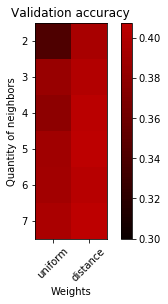

In [78]:
do_visualize_score(clf, weights, neighbors_range, 'Weights', 'Quantity of neighbors', vmin=0.3, midpoint=0.5)

f1: 0.645679338034
Train data: 40332 Test data: 6358


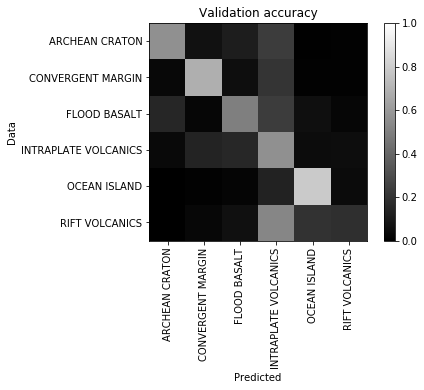

In [64]:
best_n      = 5
best_weight = 'distance'

do_validation(KNeighborsClassifier(n_neighbors=best_n, weights=best_weight))

### 3) Random forest

In [84]:
range_1 = np.arange(1, 5)
range_2 = np.arange(0.2, 0.9, 0.2)
# estimators_range = np.arange(10, 101, 20)
param_grid = dict(extratreesclassifier__min_samples_leaf=range_1,
                  extratreesclassifier__max_features=range_2)

clf = do_grid_search(ExtraTreesClassifier(class_weight='balanced', max_depth=40, n_estimators=90), param_grid, True)

Start time : 2017-07-25 11:01:27.295418
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=1 
[CV] extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=1 
[CV] extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=2 
[CV] extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=2 
[CV] extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=3 
[CV] extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=3 
[CV] extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=4 
[CV] extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=4 
[CV] extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=1 
[CV] extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=1 
[CV] extratreesclassifier__ma

/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/sit

[CV]  extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=3, total=   3.8s
[CV]  extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=4, total=   3.9s
[CV]  extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=4, total=   3.9s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done   3 out of  32 | elapsed:    5.2s remaining:   50.5s
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=3, total=   4.4s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=2, total=   4.7s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=1, total=   4.9s
[CV]  extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=2, total=   5.2s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=3, total=   5.4s
[CV]  extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=4, total=   5.2s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.2, extratreesclassifier__min_samples_leaf=1, total=   5.8s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=3, total=   5.8s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=4, total=   5.8s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=2, total=   6.0s
[CV]  extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=2, total=   6.1s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.6, extratreesclassifier__min_samples_leaf=3, total=   6.6s
[CV]  extratreesclassifier__max_features=0.6, extratreesclassifier__min_samples_leaf=4, total=   6.3s
[CV]  extratreesclassifier__max_features=0.6, extratreesclassifier__min_samples_leaf=3, total=   6.7s
[CV]  extratreesclassifier__max_features=0.6, extratreesclassifier__min_samples_leaf=4, total=   6.7s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=1, total=   6.9s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.4, extratreesclassifier__min_samples_leaf=1, total=   7.0s
[CV]  extratreesclassifier__max_features=0.6, extratreesclassifier__min_samples_leaf=2, total=   7.2s


[Parallel(n_jobs=-1)]: Done  20 out of  32 | elapsed:    8.5s remaining:    5.1s
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.6, extratreesclassifier__min_samples_leaf=2, total=   7.6s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.8, extratreesclassifier__min_samples_leaf=4, total=   7.9s
[CV]  extratreesclassifier__max_features=0.8, extratreesclassifier__min_samples_leaf=4, total=   7.7s
[CV]  extratreesclassifier__max_features=0.6, extratreesclassifier__min_samples_leaf=1, total=   8.2s
[CV]  extratreesclassifier__max_features=0.6, extratreesclassifier__min_samples_leaf=1, total=   8.0s
[CV]  extratreesclassifier__max_features=0.8, extratreesclassifier__min_samples_leaf=3, total=   8.4s
[CV]  extratreesclassifier__max_features=0.8, extratreesclassifier__min_samples_leaf=3, total=   8.5s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.8, extratreesclassifier__min_samples_leaf=2, total=   9.0s
[CV]  extratreesclassifier__max_features=0.8, extratreesclassifier__min_samples_leaf=2, total=   8.9s


/home/CloudyOverhead/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  extratreesclassifier__max_features=0.8, extratreesclassifier__min_samples_leaf=1, total=   9.8s
[CV]  extratreesclassifier__max_features=0.8, extratreesclassifier__min_samples_leaf=1, total=  10.0s


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   11.5s finished


Start time: 2017-07-25 11:01:46.039451
Time elapsed: 0:00:18.744033 

Best parameters set found on development set:
{'extratreesclassifier__max_features': 0.40000000000000002, 'extratreesclassifier__min_samples_leaf': 1}
Score: 0.423


Mean scores: 
 [[ 0.40888856  0.40458103  0.3991417   0.39885587]
 [ 0.42291301  0.41227652  0.40208592  0.3980537 ]
 [ 0.41907632  0.40947509  0.40201184  0.40309837]
 [ 0.42174028  0.41193926  0.40232769  0.40505723]]
Standard deviation: 
 [[ 0.04344613  0.00332679  0.02376276  0.03661499]
 [ 0.0486602   0.00669279  0.0083807   0.02767407]
 [ 0.05277017  0.01081559  0.01090271  0.03098989]
 [ 0.04789464  0.01051342  0.00908903  0.01687439]]


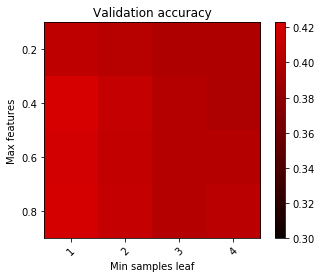

In [85]:
do_visualize_score(clf, range_1, range_2, 'Min samples leaf', 'Max features', vmin=0.3, midpoint=0.5)

f1: 0.670819194818
Train data: 40332 Test data: 6358


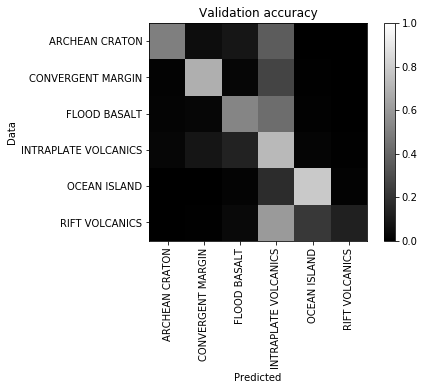

In [93]:
best_depth      = 50
best_estimators = 100
best_leaf       = 1
best_features   = 0.4

clf = ExtraTreesClassifier(max_depth=best_depth, 
                           n_estimators=best_estimators, 
                           min_samples_leaf=best_leaf, 
                           max_features=best_features,  
                           class_weight='balanced')

do_validation(clf)

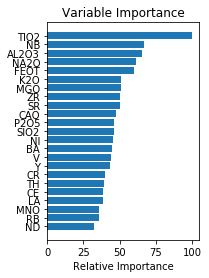

In [94]:
# Importance of each element regarding classification.

feature_importance = clf.feature_importances_
feature_importance = 100 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, filtered_file.iloc[:, 28:-1].axes[1].values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [107]:
# Formatting data. Aims at reducing data closure (each element's weight depend on the others', as weights are in percentage).

_X = make_CLR(X)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000


In [ ]:
# Visualizing decision boundaries  # DEPRECATED

from matplotlib.colors import ListedColormap

# PARAMETERS #
best_depth      = 50
best_estimators = 100
best_leaf       = 3
best_features   = 0.8

h = 0.2
p_samples = 0.2
##############

n = 1

fig = plt.figure(figsize=(20, 20))

for pair in combinations([0, 1, 2], 2):
    # Taking the two corresponding features
    X_ = _X.iloc[:, list(pair)]
    y_ = to_int(y)

    x_min, x_max = X_.iloc[:, 0].min() - h, X_.iloc[:, 0].max() + h
    y_min, y_max = X_.iloc[:, 1].min() - h, X_.iloc[:, 1].max() + h

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Train
    clf = ExtraTreesClassifier(max_depth=best_depth,
                           n_estimators=best_estimators,
                           min_samples_leaf=best_leaf,
                           max_features=best_features,
                           class_weight='balanced')
    clf = clf.fit(X_, y_)

    # Plot the decision boundary
    fig.add_subplot(3, 3, n)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(filtered_file.iloc[:, 28:-1].axes[1].tolist()[pair[0]])
    plt.ylabel(filtered_file.iloc[:, 28:-1].axes[1].tolist()[pair[1]])
    plt.axis("tight")

    # Plot the training points
    labels = filtered_file.iloc[:, 28:-1].axes[1].tolist()
    for k, color in zip(range(len(y_test.value_counts())), "rgbycm"):
        kdx = np.where(y_ == k)
        size_ = int(len(X_) * p_samples)
        np.random.seed(42)
        filt_X = np.random.choice(X_.as_matrix()[kdx, 0].reshape([-1]), size_)
        np.random.seed(42)
        filt_y = np.random.choice(X_.as_matrix()[kdx, 1].reshape([-1]), size_)
        plt.scatter(filt_X, filt_y, c=color, label=labels[k], cmap=plt.cm.Paired)

    n += 1

r_ = mpatches.Patch(color='red',     label='ARCHEAN CRATON')
g_ = mpatches.Patch(color='green',   label='CONVERGENT MARGIN')
b_ = mpatches.Patch(color='blue',    label='FLOOD BASALT')
y_ = mpatches.Patch(color='yellow',  label='INTRAPLATE VOLCANICS')
c_ = mpatches.Patch(color='cyan',    label='OCEAN ISLAND')
m_ = mpatches.Patch(color='magenta', label='RIFT VOLCANICS')
plt.legend(handles=[r_, g_, b_, y_, c_, m_]);

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 18676
[t-SNE] Computed conditional probabilities for sample 2000 / 18676
[t-SNE] Computed conditional probabilities for sample 3000 / 18676
[t-SNE] Computed conditional probabilities for sample 4000 / 18676
[t-SNE] Computed conditional probabilities for sample 5000 / 18676
[t-SNE] Computed conditional probabilities for sample 6000 / 18676
[t-SNE] Computed conditional probabilities for sample 7000 / 18676
[t-SNE] Computed conditional probabilities for sample 8000 / 18676
[t-SNE] Computed conditional probabilities for sample 9000 / 18676
[t-SNE] Computed conditional probabilities for sample 10000 / 18676
[t-SNE] Computed conditional probabilities for sample 11000 / 18676
[t-SNE] Computed conditional probabilities for sample 12000 / 18676
[t-SNE] Computed conditional probabilities for sample 13000 / 18676
[t-SNE] Computed conditional probabilities

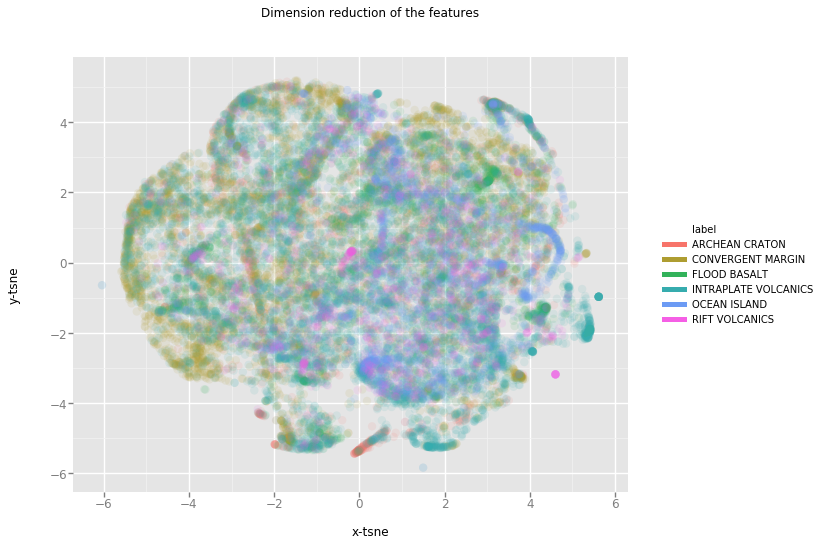

<ggplot: (-9223363291160167620)>


In [101]:
# Dimensions reduction. Shows how well data is splitted in the 20-something dimensions space.

from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from ggplot import *

temp_X, _, temp_y, _ = train_test_split(X, y, train_size=0.4)

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(temp_X.values)

df_tsne = temp_X.copy()
df_tsne['x-tsne'] = tsne_results[:, 0]
df_tsne['y-tsne'] = tsne_results[:, 1]
df_tsne['label'] = temp_y

chart = (ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label')) +
         geom_point(size=70,alpha=0.1) +
         ggtitle("Dimension reduction of the features"))
print(chart)

### 4) Deep learning - sklearn's Perceptron

In [61]:
range_1 = [(65,) * 2, (65,) * 3, (65,) * 4]
range_2 = 10.0 ** np.arange(-5, -2)
param_grid = dict(mlpclassifier__hidden_layer_sizes=range_1,
                  mlpclassifier__alpha=range_2)

clf = do_grid_search(MLPClassifier(tol=5 * 10e-3), param_grid, True, n_out=30)

Start time : 2017-07-31 09:30:01.916980
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65) 
[CV] mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65) 
[CV] mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65, 65) 
[CV] mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65, 65) 
[CV] mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65, 65, 65) 
[CV] mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65, 65, 65) 
[CV] mlpclassifier__alpha=0.0001, mlpclassifier__hidden_layer_sizes=(65, 65) 
[CV] mlpclassifier__alpha=0.0001, mlpclassifier__hidden_layer_sizes=(65, 65) 
[CV] mlpclassifier__alpha=0.0001, mlpclassifier__hidden_layer_sizes=(65, 65, 65) 
[CV] mlpclassifier__alpha=0.0001, mlpclassifier__hidden_layer_sizes=(65, 65, 65) 
[CV] mlpclassifier__alpha=0.0001, mlpclassifier__hidden_layer_sizes=(65, 65, 65, 65) 
[CV] mlp

[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:   43.4s remaining:  1.9min


[CV]  mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65), total=  39.2s
[CV]  mlpclassifier__alpha=0.0001, mlpclassifier__hidden_layer_sizes=(65, 65, 65), total=  48.3s
[CV]  mlpclassifier__alpha=0.001, mlpclassifier__hidden_layer_sizes=(65, 65, 65), total=  48.0s
[CV]  mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65, 65), total=  48.7s
[CV]  mlpclassifier__alpha=0.0001, mlpclassifier__hidden_layer_sizes=(65, 65, 65), total=  49.5s
[CV]  mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65, 65), total=  50.3s
[CV]  mlpclassifier__alpha=0.001, mlpclassifier__hidden_layer_sizes=(65, 65, 65), total=  50.9s
[CV]  mlpclassifier__alpha=0.0001, mlpclassifier__hidden_layer_sizes=(65, 65, 65, 65), total=  52.1s
[CV]  mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65, 65, 65), total=  52.6s
[CV]  mlpclassifier__alpha=0.001, mlpclassifier__hidden_layer_sizes=(65, 65, 65, 65), total=  53.8s
[CV]  mlpclassifier__alpha=0.

[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   55.3s remaining:   11.1s


[CV]  mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(65, 65, 65, 65), total=  54.6s


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   55.6s finished


Start time: 2017-07-31 09:31:01.358195
Time elapsed: 0:00:59.441215 

Best parameters set found on development set:
{'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (65, 65)}
Score: 0.524


Mean scores: 
 [[ 0.523053    0.50985389  0.50413132]
 [ 0.52380521  0.51248074  0.50816358]
 [ 0.52315549  0.51436162  0.50516513]]
Standard deviation: 
 [[ 0.03488287  0.03670536  0.0388454 ]
 [ 0.03522423  0.03742059  0.03708917]
 [ 0.03320223  0.03726003  0.03460021]]


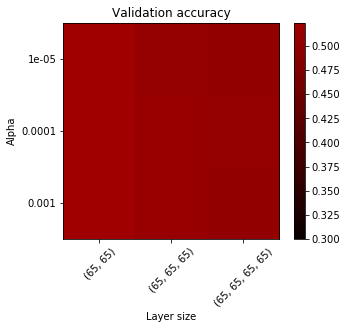

In [62]:
do_visualize_score(clf, range_1, range_2, 'Layer size', 'Alpha', vmin=0.3, midpoint=0.8)

f1: 0.556487075998
Train data: 42501 Test data: 4189


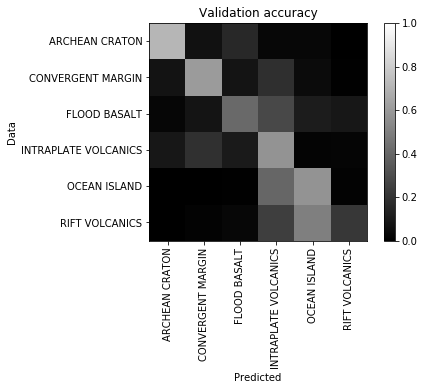

In [64]:
best_layers = (65,) * 2
best_alpha  = 0.0001

do_validation(MLPClassifier(hidden_layer_sizes=best_layers, alpha=best_alpha, tol=5 * 10e-3))

In [ ]:
# Reliability test. Takes one validation file at a time and computes score across the whole database.

# PARAMETERS #
n_files = 234  # / 234
n_out   = 100  # / 233
##############

import warnings

X = filtered_file.iloc[:, 28:-1].astype(float)
y = filtered_file['TECTONIC SETTING']
counts = filtered_file['TECTONIC SETTING'].value_counts()
f_counts = filtered_file.groupby('FILENAME').first()['TECTONIC SETTING'].value_counts()

score = 0
s_score = 0
f_score = 0
w_score = 0

warnings.filterwarnings('ignore')

for no, (train_ind, test_ind) in enumerate(file_split_gen(filtered_file['FILENAME'], n_out=1, n_splits=n_files)):

    X_train, X_test = X.iloc[train_ind].reset_index(drop=True), X.iloc[test_ind].reset_index(drop=True)
    y_train, y_test = y.iloc[train_ind].reset_index(drop=True), y.iloc[test_ind].reset_index(drop=True)
    filenames_train = filtered_file['FILENAME'].iloc[train_ind].reset_index(drop=True)

    range_1 = [(65,) * 2, (65,) * 3, (65,) * 4]
    range_2 = 10.0 ** np.arange(-5, -2)
    param_grid = dict(mlpclassifier__hidden_layer_sizes=range_1,
                          mlpclassifier__alpha=range_2)
    clf = do_grid_search(MLPClassifier(tol=5 * 10e-3), param_grid, True, n_out=n_out, verbose=False)

    best_layers = clf.cv_results_['params'][clf.best_index_]['mlpclassifier__hidden_layer_sizes']
    best_alpha  = clf.cv_results_['params'][clf.best_index_]['mlpclassifier__alpha']
    f1 = do_validation(MLPClassifier(hidden_layer_sizes=best_layers, alpha=best_alpha, tol=5 * 10e-3), verbose=False)

    score += f1
    s_score += f1 * len(y_test) / filtered_file.shape[0]

    count_ = y_test.value_counts()

    for row in count_.iteritems():
        print(no + 1, row, f1, (best_layers, best_alpha))
        f_score += f1 / f_counts[row[0]] / 6
        w_score += row[1] / counts[row[0]] * f1 / 6 

print()
print('Average score across files is:   ', score / n_files)
print('Average score across samples is: ', s_score)
print('Weighted score across files is:  ', f_score)
print('Weighted score across samples is:', w_score)

warnings.filterwarnings('always')

### 5) Deep learning - TensorFlow

Regular convolutional neural networks have generated good results on the database, even though the current problem isn't fit for such neural networks. This suggests exotic types of convolutional neural networks (types which would be more appropriate) would achieve much better accuracies and convergence times than typical machine learning algorithms. Following code is adaptated from examples from the TensorFlow website.

#### Periodic table convolution

As periodic table neighbors share the strongest relationships, operating a convolutional neural network on data arranged in a 3D tensor (rather than a table) may give better results and converge faster.

In [76]:
# Rearrange data in a 4D tensor of shape (nb_samples, height, width, chromaticity_dimensions). The latter is 1, as data is
# essentially a monochromatic *image*.

periodic_table = [['NA2O', 'MGO', 'AL2O3', 'SIO2', 'P2O5'],
                  ['K2O',  'CAO', 'SC',    'TIO2', 'MNO' ],
                  ['RB',   'SR',  'Y',     'ZR',   'NB'  ],
                  ['TH',   'BA',  'CE',    'HF',   'TA'  ]]
periodic_table_sizes = (len(periodic_table), len(periodic_table[0]))

def tensor_4D(matrix):
    tensor = np.ndarray(shape=(matrix.shape[0], *periodic_table_sizes, 1))

    for row_no, row in enumerate(periodic_table):
        for col_no, item in enumerate(row):
            tensor[:, row_no, col_no, 0] = matrix[item].as_matrix()

    return tensor

In [77]:
def convolutional_model(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features, [-1, *periodic_table_sizes, 1])

    # Convolutional Layer #1 and Pooling Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=64,
        kernel_size=[4, 3],
        padding="same",
        activation=tf.nn.relu)
    # pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[1, 1], strides=1)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[4, 3],
        padding="same",
        activation=tf.nn.relu)
    # pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[1, 1], strides=1)
    shape_ = conv2.get_shape().as_list()

    # Dense Layer
    pool2_flat = tf.reshape(conv2, [-1, shape_[1] * shape_[2] * shape_[3]])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == learn.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=6)

    loss = None
    train_op = None

    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=6)
        loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
          loss=loss,
          global_step=tf.contrib.framework.get_global_step(),
          learning_rate=0.00001,
          optimizer="Adam")

    # Generate Predictions
    predictions = {"classes": tf.argmax(input=logits, axis=1), 
                   "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}

    # Return a ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc66687e0f0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
(5927, 4, 5, 1) (5927,)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/model4/model.ckpt.
INFO:tensorflow:loss = 9104.15, step = 1
INFO:tensorflow:global_step/sec: 53.619
INFO:tensorflow:loss = 4502.38, step = 101 (1.867 sec)
INFO:tensorflow:global_step/sec: 55.0443
INFO:tensorflow:loss = 2760.41, step = 201 (1.817 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 53.9807
INFO:tensorflow:loss = 1.60132, step = 7801 (1.852 sec)
INFO:tensorflow:global_step/sec: 54.5501
INFO:tensorflow:loss = 1.73547, step = 7901 (1.833 sec)
INFO:tensorflow:global_step/sec: 53.6387
INFO:tensorflow:loss = 1.83286, step = 8001 (1.864 sec)
INFO:tensorflow:global_step/sec: 53.9462
INFO:tensorflow:loss = 1.83047, step = 8101 (1.854 sec)
INFO:tensorflow:global_step/sec: 53.482
INFO:tensorflow:loss = 1.60381, step = 8201 (1.870 sec)
INFO:tensorflow:global_step/sec: 52.975
INFO:tensorflow:loss = 1.60875, step = 8301 (1.888 sec)
INFO:tensorflow:global_step/sec: 54.1293
INFO:tensorflow:loss = 1.79929, step = 8401 (1.847 sec)
INFO:tensorflow:global_step/sec: 54.6214
INFO:tensorflow:loss = 1.57387, step = 8501 (1.831 sec)
INFO:tensorflow:global_step/sec: 54.2493
INFO:tensorflow:loss = 2.02878, step = 8601 (1.843 sec)
INFO:tensorflow:global_step/sec: 54.3749
INFO:tensorflow:loss = 1.60308, step = 8701 (1.839 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:loss = 1.57134, step = 16201 (1.882 sec)
INFO:tensorflow:global_step/sec: 53.9661
INFO:tensorflow:loss = 1.50406, step = 16301 (1.853 sec)
INFO:tensorflow:global_step/sec: 53.8679
INFO:tensorflow:loss = 1.50631, step = 16401 (1.856 sec)
INFO:tensorflow:global_step/sec: 55.1323
INFO:tensorflow:loss = 1.50607, step = 16501 (1.814 sec)
INFO:tensorflow:global_step/sec: 55.6776
INFO:tensorflow:loss = 1.56535, step = 16601 (1.795 sec)
INFO:tensorflow:global_step/sec: 55.7986
INFO:tensorflow:loss = 1.46777, step = 16701 (1.792 sec)
INFO:tensorflow:global_step/sec: 54.9196
INFO:tensorflow:loss = 1.50569, step = 16801 (1.821 sec)
INFO:tensorflow:global_step/sec: 53.8513
INFO:tensorflow:loss = 1.54001, step = 16901 (1.858 sec)
INFO:tensorflow:global_step/sec: 53.8416
INFO:tensorflow:loss = 1.51993, step = 17001 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.3753
INFO:tensorflow:loss = 1.50509, step = 17101 (1.873 sec)
INFO:tensorflow:global_step/sec: 53.7396
INFO:tensorflow:loss

INFO:tensorflow:loss = 1.53506, step = 24601 (1.860 sec)
INFO:tensorflow:global_step/sec: 53.9338
INFO:tensorflow:loss = 1.53039, step = 24701 (1.854 sec)
INFO:tensorflow:global_step/sec: 53.6364
INFO:tensorflow:loss = 1.51406, step = 24801 (1.864 sec)
INFO:tensorflow:global_step/sec: 53.9166
INFO:tensorflow:loss = 1.48069, step = 24901 (1.855 sec)
INFO:tensorflow:global_step/sec: 53.6241
INFO:tensorflow:loss = 1.53122, step = 25001 (1.865 sec)
INFO:tensorflow:global_step/sec: 53.6808
INFO:tensorflow:loss = 1.40845, step = 25101 (1.863 sec)
INFO:tensorflow:global_step/sec: 54.5231
INFO:tensorflow:loss = 1.46402, step = 25201 (1.834 sec)
INFO:tensorflow:global_step/sec: 53.1074
INFO:tensorflow:loss = 1.51643, step = 25301 (1.883 sec)
INFO:tensorflow:global_step/sec: 53.4537
INFO:tensorflow:loss = 1.42419, step = 25401 (1.871 sec)
INFO:tensorflow:global_step/sec: 53.9294
INFO:tensorflow:loss = 1.459, step = 25501 (1.854 sec)
INFO:tensorflow:global_step/sec: 53.8302
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 53.6359
INFO:tensorflow:loss = 1.42245, step = 33001 (1.864 sec)
INFO:tensorflow:global_step/sec: 55.0391
INFO:tensorflow:loss = 1.5754, step = 33101 (1.817 sec)
INFO:tensorflow:global_step/sec: 54.2233
INFO:tensorflow:loss = 1.37152, step = 33201 (1.844 sec)
INFO:tensorflow:global_step/sec: 53.0114
INFO:tensorflow:loss = 1.79887, step = 33301 (1.886 sec)
INFO:tensorflow:global_step/sec: 53.6819
INFO:tensorflow:loss = 1.46368, step = 33401 (1.863 sec)
INFO:tensorflow:global_step/sec: 54.1352
INFO:tensorflow:loss = 1.42917, step = 33501 (1.847 sec)
INFO:tensorflow:global_step/sec: 53.0972
INFO:tensorflow:loss = 1.49965, step = 33601 (1.883 sec)
INFO:tensorflow:global_step/sec: 53.58
INFO:tensorflow:loss = 1.47285, step = 33701 (1.866 sec)
INFO:tensorflow:global_step/sec: 54.3166
INFO:tensorflow:loss = 1.50146, step = 33801 (1.841 sec)
INFO:tensorflow:global_step/sec: 53.1643
INFO:tensorflow:loss = 1.36841, step = 33901 (1.881 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 53.8162
INFO:tensorflow:loss = 1.33014, step = 41401 (1.858 sec)
INFO:tensorflow:global_step/sec: 53.9246
INFO:tensorflow:loss = 1.38203, step = 41501 (1.855 sec)
INFO:tensorflow:global_step/sec: 53.8183
INFO:tensorflow:loss = 1.34757, step = 41601 (1.858 sec)
INFO:tensorflow:global_step/sec: 53.7261
INFO:tensorflow:loss = 1.36088, step = 41701 (1.861 sec)
INFO:tensorflow:global_step/sec: 53.3127
INFO:tensorflow:loss = 1.41797, step = 41801 (1.876 sec)
INFO:tensorflow:global_step/sec: 53.5049
INFO:tensorflow:loss = 1.40924, step = 41901 (1.869 sec)
INFO:tensorflow:global_step/sec: 54.7508
INFO:tensorflow:loss = 1.33152, step = 42001 (1.827 sec)
INFO:tensorflow:global_step/sec: 54.0412
INFO:tensorflow:loss = 1.40919, step = 42101 (1.850 sec)
INFO:tensorflow:global_step/sec: 54.2444
INFO:tensorflow:loss = 1.34847, step = 42201 (1.844 sec)
INFO:tensorflow:global_step/sec: 53.7845
INFO:tensorflow:loss = 1.32872, step = 42301 (1.859 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 53.3707
INFO:tensorflow:loss = 1.38041, step = 49801 (1.874 sec)
INFO:tensorflow:global_step/sec: 54.3686
INFO:tensorflow:loss = 1.39527, step = 49901 (1.839 sec)
INFO:tensorflow:global_step/sec: 53.791
INFO:tensorflow:loss = 1.35953, step = 50001 (1.859 sec)
INFO:tensorflow:global_step/sec: 53.6522
INFO:tensorflow:loss = 1.27939, step = 50101 (1.864 sec)
INFO:tensorflow:global_step/sec: 53.6047
INFO:tensorflow:loss = 1.38506, step = 50201 (1.865 sec)
INFO:tensorflow:global_step/sec: 52.9136
INFO:tensorflow:loss = 1.37834, step = 50301 (1.890 sec)
INFO:tensorflow:global_step/sec: 54.0117
INFO:tensorflow:loss = 1.33032, step = 50401 (1.851 sec)
INFO:tensorflow:global_step/sec: 54.1949
INFO:tensorflow:loss = 1.4239, step = 50501 (1.845 sec)
INFO:tensorflow:global_step/sec: 51.906
INFO:tensorflow:loss = 1.36215, step = 50601 (1.927 sec)
INFO:tensorflow:global_step/sec: 53.8688
INFO:tensorflow:loss = 1.47722, step = 50701 (1.856 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 53.4937
INFO:tensorflow:loss = 1.27284, step = 58201 (1.869 sec)
INFO:tensorflow:global_step/sec: 54.0617
INFO:tensorflow:loss = 1.327, step = 58301 (1.850 sec)
INFO:tensorflow:global_step/sec: 53.9944
INFO:tensorflow:loss = 1.34675, step = 58401 (1.852 sec)
INFO:tensorflow:global_step/sec: 54.1509
INFO:tensorflow:loss = 1.37602, step = 58501 (1.846 sec)
INFO:tensorflow:global_step/sec: 53.752
INFO:tensorflow:loss = 1.35915, step = 58601 (1.860 sec)
INFO:tensorflow:global_step/sec: 53.4195
INFO:tensorflow:loss = 1.40785, step = 58701 (1.872 sec)
INFO:tensorflow:global_step/sec: 53.5092
INFO:tensorflow:loss = 1.40485, step = 58801 (1.869 sec)
INFO:tensorflow:global_step/sec: 53.3218
INFO:tensorflow:loss = 1.34348, step = 58901 (1.875 sec)
INFO:tensorflow:global_step/sec: 54.3337
INFO:tensorflow:loss = 1.34698, step = 59001 (1.841 sec)
INFO:tensorflow:global_step/sec: 54.4574
INFO:tensorflow:loss = 1.35597, step = 59101 (1.836 sec)
INFO:tensorflow:global_

INFO:tensorflow:loss = 1.33981, step = 66501 (1.863 sec)
INFO:tensorflow:global_step/sec: 54.5688
INFO:tensorflow:loss = 1.32757, step = 66601 (1.833 sec)
INFO:tensorflow:global_step/sec: 54.31
INFO:tensorflow:loss = 1.38035, step = 66701 (1.841 sec)
INFO:tensorflow:global_step/sec: 53.9986
INFO:tensorflow:loss = 1.32001, step = 66801 (1.852 sec)
INFO:tensorflow:global_step/sec: 53.7807
INFO:tensorflow:loss = 1.28666, step = 66901 (1.859 sec)
INFO:tensorflow:global_step/sec: 54.0892
INFO:tensorflow:loss = 1.32642, step = 67001 (1.849 sec)
INFO:tensorflow:global_step/sec: 53.8337
INFO:tensorflow:loss = 1.28841, step = 67101 (1.858 sec)
INFO:tensorflow:global_step/sec: 53.6106
INFO:tensorflow:loss = 1.21893, step = 67201 (1.865 sec)
INFO:tensorflow:global_step/sec: 53.8489
INFO:tensorflow:loss = 1.40869, step = 67301 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.7658
INFO:tensorflow:loss = 1.27082, step = 67401 (1.860 sec)
INFO:tensorflow:global_step/sec: 54.7596
INFO:tensorflow:loss =

INFO:tensorflow:loss = 1.32533, step = 74901 (1.853 sec)
INFO:tensorflow:global_step/sec: 53.7298
INFO:tensorflow:loss = 1.33956, step = 75001 (1.861 sec)
INFO:tensorflow:global_step/sec: 53.4493
INFO:tensorflow:loss = 1.32487, step = 75101 (1.871 sec)
INFO:tensorflow:global_step/sec: 53.1023
INFO:tensorflow:loss = 1.31211, step = 75201 (1.883 sec)
INFO:tensorflow:global_step/sec: 54.1013
INFO:tensorflow:loss = 1.23282, step = 75301 (1.848 sec)
INFO:tensorflow:global_step/sec: 54.7777
INFO:tensorflow:loss = 1.30941, step = 75401 (1.826 sec)
INFO:tensorflow:global_step/sec: 53.6293
INFO:tensorflow:loss = 1.28255, step = 75501 (1.865 sec)
INFO:tensorflow:global_step/sec: 54.7628
INFO:tensorflow:loss = 1.22937, step = 75601 (1.826 sec)
INFO:tensorflow:global_step/sec: 52.8923
INFO:tensorflow:loss = 1.31888, step = 75701 (1.891 sec)
INFO:tensorflow:global_step/sec: 54.3798
INFO:tensorflow:loss = 1.3703, step = 75801 (1.839 sec)
INFO:tensorflow:global_step/sec: 53.7797
INFO:tensorflow:loss 

INFO:tensorflow:loss = 1.23194, step = 83301 (1.843 sec)
INFO:tensorflow:global_step/sec: 54.101
INFO:tensorflow:loss = 1.35005, step = 83401 (1.848 sec)
INFO:tensorflow:global_step/sec: 53.994
INFO:tensorflow:loss = 1.36216, step = 83501 (1.852 sec)
INFO:tensorflow:global_step/sec: 54.0854
INFO:tensorflow:loss = 1.26209, step = 83601 (1.849 sec)
INFO:tensorflow:global_step/sec: 53.6491
INFO:tensorflow:loss = 1.28001, step = 83701 (1.864 sec)
INFO:tensorflow:global_step/sec: 53.8917
INFO:tensorflow:loss = 1.31295, step = 83801 (1.856 sec)
INFO:tensorflow:global_step/sec: 53.8567
INFO:tensorflow:loss = 1.30469, step = 83901 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.7802
INFO:tensorflow:loss = 1.26759, step = 84001 (1.859 sec)
INFO:tensorflow:global_step/sec: 54.1305
INFO:tensorflow:loss = 1.29636, step = 84101 (1.847 sec)
INFO:tensorflow:global_step/sec: 53.8194
INFO:tensorflow:loss = 1.39876, step = 84201 (1.858 sec)
INFO:tensorflow:global_step/sec: 54.6668
INFO:tensorflow:loss =

INFO:tensorflow:loss = 1.25906, step = 91701 (1.873 sec)
INFO:tensorflow:global_step/sec: 53.9571
INFO:tensorflow:loss = 1.26179, step = 91801 (1.854 sec)
INFO:tensorflow:global_step/sec: 53.911
INFO:tensorflow:loss = 1.27667, step = 91901 (1.855 sec)
INFO:tensorflow:global_step/sec: 53.8614
INFO:tensorflow:loss = 1.33482, step = 92001 (1.857 sec)
INFO:tensorflow:global_step/sec: 54.2066
INFO:tensorflow:loss = 1.2844, step = 92101 (1.845 sec)
INFO:tensorflow:global_step/sec: 53.7677
INFO:tensorflow:loss = 1.3561, step = 92201 (1.860 sec)
INFO:tensorflow:global_step/sec: 53.7064
INFO:tensorflow:loss = 1.20058, step = 92301 (1.862 sec)
INFO:tensorflow:global_step/sec: 54.3578
INFO:tensorflow:loss = 1.22375, step = 92401 (1.840 sec)
INFO:tensorflow:global_step/sec: 53.7611
INFO:tensorflow:loss = 1.22589, step = 92501 (1.860 sec)
INFO:tensorflow:global_step/sec: 53.2733
INFO:tensorflow:loss = 1.28149, step = 92601 (1.877 sec)
INFO:tensorflow:global_step/sec: 52.8419
INFO:tensorflow:loss = 

INFO:tensorflow:loss = 1.25333, step = 100001 (1.842 sec)
INFO:tensorflow:global_step/sec: 54.2682
INFO:tensorflow:loss = 1.26397, step = 100101 (1.843 sec)
INFO:tensorflow:global_step/sec: 53.447
INFO:tensorflow:loss = 1.28838, step = 100201 (1.871 sec)
INFO:tensorflow:global_step/sec: 54.3251
INFO:tensorflow:loss = 1.2773, step = 100301 (1.841 sec)
INFO:tensorflow:global_step/sec: 53.8168
INFO:tensorflow:loss = 1.30431, step = 100401 (1.858 sec)
INFO:tensorflow:global_step/sec: 54.1781
INFO:tensorflow:loss = 1.30573, step = 100501 (1.846 sec)
INFO:tensorflow:global_step/sec: 54.1641
INFO:tensorflow:loss = 1.30241, step = 100601 (1.846 sec)
INFO:tensorflow:global_step/sec: 53.8401
INFO:tensorflow:loss = 1.21729, step = 100701 (1.857 sec)
INFO:tensorflow:global_step/sec: 54.8656
INFO:tensorflow:loss = 1.27369, step = 100801 (1.823 sec)
INFO:tensorflow:global_step/sec: 53.9146
INFO:tensorflow:loss = 1.23933, step = 100901 (1.855 sec)
INFO:tensorflow:global_step/sec: 54.0318
INFO:tensorf

INFO:tensorflow:loss = 1.16626, step = 108301 (1.834 sec)
INFO:tensorflow:global_step/sec: 53.8313
INFO:tensorflow:loss = 1.17526, step = 108401 (1.858 sec)
INFO:tensorflow:global_step/sec: 53.8045
INFO:tensorflow:loss = 1.23063, step = 108501 (1.859 sec)
INFO:tensorflow:global_step/sec: 53.8951
INFO:tensorflow:loss = 1.16912, step = 108601 (1.855 sec)
INFO:tensorflow:global_step/sec: 54.4661
INFO:tensorflow:loss = 1.23199, step = 108701 (1.836 sec)
INFO:tensorflow:global_step/sec: 53.566
INFO:tensorflow:loss = 1.29014, step = 108801 (1.867 sec)
INFO:tensorflow:global_step/sec: 53.9959
INFO:tensorflow:loss = 1.27203, step = 108901 (1.852 sec)
INFO:tensorflow:global_step/sec: 54.3578
INFO:tensorflow:loss = 1.25527, step = 109001 (1.840 sec)
INFO:tensorflow:global_step/sec: 52.8786
INFO:tensorflow:loss = 1.13594, step = 109101 (1.891 sec)
INFO:tensorflow:global_step/sec: 54.9926
INFO:tensorflow:loss = 1.22892, step = 109201 (1.818 sec)
INFO:tensorflow:global_step/sec: 53.7827
INFO:tensor

INFO:tensorflow:loss = 1.2536, step = 116601 (1.853 sec)
INFO:tensorflow:global_step/sec: 54.5953
INFO:tensorflow:loss = 1.22885, step = 116701 (1.832 sec)
INFO:tensorflow:global_step/sec: 53.9453
INFO:tensorflow:loss = 1.29662, step = 116801 (1.854 sec)
INFO:tensorflow:global_step/sec: 53.3146
INFO:tensorflow:loss = 1.35537, step = 116901 (1.876 sec)
INFO:tensorflow:global_step/sec: 54.0158
INFO:tensorflow:loss = 1.2176, step = 117001 (1.851 sec)
INFO:tensorflow:global_step/sec: 53.9768
INFO:tensorflow:loss = 1.34038, step = 117101 (1.853 sec)
INFO:tensorflow:global_step/sec: 54.1972
INFO:tensorflow:loss = 1.25605, step = 117201 (1.845 sec)
INFO:tensorflow:global_step/sec: 53.8101
INFO:tensorflow:loss = 1.13566, step = 117301 (1.858 sec)
INFO:tensorflow:global_step/sec: 54.202
INFO:tensorflow:loss = 1.24782, step = 117401 (1.845 sec)
INFO:tensorflow:global_step/sec: 54.1041
INFO:tensorflow:loss = 1.22768, step = 117501 (1.848 sec)
INFO:tensorflow:global_step/sec: 54.2171
INFO:tensorfl

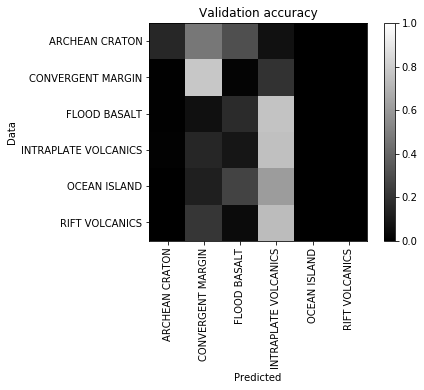

In [78]:
# Create the Estimator
classifier = learn.SKCompat(learn.Estimator(model_fn=convolutional_model, model_dir="/tmp/model4"))

# Format data
with tf.Session() as session:
    X_tf_train, X_tf_test = tensor_4D(X_train), tensor_4D(X_test)
    X_tf_train, X_tf_test = session.run([tf.cast(X_tf_train, tf.float32), tf.cast(X_tf_test, tf.float32)])
    y_tf_train, y_tf_test = to_int(y_train).as_matrix(), to_int(y_test).as_matrix()  # to_one_hot(to_int(y_train)), to_one_hot(to_int(y_test))
    y_tf_train, y_tf_test = session.run([tf.cast(y_tf_train, tf.float32), tf.cast(y_tf_test, tf.float32)])

print(X_tf_test.shape, y_tf_test.shape)
# Train the model
classifier.fit(x=X_tf_train, y=y_tf_train, batch_size=200, steps=120000)

# Evaluate the model and print results
eval_results = classifier.predict(x=X_tf_test)['classes']

with tf.Session() as session:
    conf = tf.confusion_matrix(y_tf_test, eval_results).eval()

print('\n', f1_score(y_tf_test, eval_results, average='weighted'))
print_confusion_matrix(conf)

## Comparison with other methods:

In [ ]:
# Prepares the sets associated with each graph from [1]. Elements needed: NB, V, Y, ZR, TIO2

set_ = filtered_file[filtered_file['TECTONIC SETTING'] in (,)]
set_y = set_['TECTONIC SETTING'].str.replace({'':'M', '':'O', '':'C', '':'I'})
set_X = set_['NB', 'V', 'Y', 'ZR', 'TIO2']

setA = (set_X, set_y)
setB = (set_X[set_y != 'M'], set_y[set_y != 'M'])
setC = (set_X[set_y != 'O'], set_y[set_y != 'O'])
setD = (set_X[set_y != 'C'], set_y[set_y != 'C'])
setE = (set_X[set_y != 'I'], set_y[set_y != 'I'])

In [ ]:
# Formats current data into coordinates for the appropriate graph.

DFA = do_to_DF_coords(setA[0], (-0.6611, 2.2926, 1.6774, 1.0916, 21.3603), (0.4702, 3.7649, -3.911, 2.2697, 4.8487))
DFB = do_to_DF_coords(setB[0], (-0.6146, 2.3510, 1.6828, 1.1911, 22.7253), (1.3765, -0.9452, 4.0461, 2.0789, 22.2450))
DFC = do_to_DF_coords(setC[0], (-0.6624, 2.4498, 1.2867, 1.0920, 18.7466), (0.4938, 3.4741, -3.8053, 2.0070, 3.3163))
DFD = do_to_DF_coords(setD[0], (-0.2646, 2.0491, 3.4565, 0.8573, 32.9472), (0.01874, 4.0937, -4.8550, 2.9900, 0.1995))
DFE = do_to_DF_coords(setE[0], (-0.7829, 0.3379, 3.3239, 0.51232, 16.0941), (1.7478, -0.0421, 3.5301, 1.4503, 28.3592))

In [ ]:
# Classifies each point according to the separation lines from each graph.

params = {
    'A': {'center': (0.64849, 0.87812),     1: {0: 0.02820,  1: 8,       's': ('CO', 'I')}, 2: {0: -3.2318,  1: -8,       's': ('CO', 'M')}, 3: {0: 8,        1: -4.5532,  's': ('M', 'I')}},
    'B': {'center': (0.883172, -0.667465),  1: {0: -8,       1: 1.66740, 's': ('C', 'O')},  2: {0: 2.27820,  1: 8,        's': ('C', 'I')},  3: {0: 1.87600,  1: -8,       's': ('O', 'I')}},
    'C': {'center': (-0.016496, 0.972583),  1: {0: -4.19440, 1: -8,      's': ('C', 'M')},  2: {0: 8,        1: -5.79920, 's': ('M', 'I')},  3: {0: -0.43580, 1: 8,        's': ('C', 'I')}},
    'D': {'center': (-0.322489, 1.040295),  1: {0: -3.72100, 1: -8,      's': ('O', 'M')},  2: {0: -0.81840, 1: 8,        's': ('O', 'I')},  3: {0: 8,        1: -4.36500, 's': ('M', 'I')}},
    'E': {'center': (1.129586, -0.4194316), 1: {0: -8,       1: 1.48500, 's': ('O', 'C')},  2: {0: 2.43000,  1: -8,       's': ('O', 'M')},  3: {0: 3.32100,  1: 8,        's': ('C', 'M')}}
         }

classA = do_DF_classification(DFA, params['A']['center'], params['A'][1], params['A'][2], params['A'][3])
classB = do_DF_classification(DFB, params['B']['center'], params['B'][1], params['B'][2], params['B'][3])
classC = do_DF_classification(DFC, params['C']['center'], params['C'][1], params['C'][2], params['C'][3])
classD = do_DF_classification(DFD, params['D']['center'], params['D'][1], params['D'][2], params['D'][3])
classE = do_DF_classification(DFE, params['E']['center'], params['E'][1], params['E'][2], params['E'][3])

In [ ]:
# Computes global scores for each graph.

f1A = f1_score(setA[1].str.replace(['C', 'O'], 'CO'), classA, average='weighted')
f1B = f1_score(setB[1], classA, average='weighted')
f1C = f1_score(setC[1], classA, average='weighted')
f1D = f1_score(setD[1], classA, average='weighted')
f1E = f1_score(setE[1], classA, average='weighted')

print('f1 scores:', 'A:', f1A, 'B:', f1B, 'C:', f1C, 'D:', f1D, 'E:', f1E)

In [ ]:
# Visualizing graphs with data from the current database.

# from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(20, 20))

ref = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E'}

for n, scatter in enumerate(DFA, DFB, DFC, DFD, DFE):
    fig.add_subplot(3, 3, n + 1)
    m = ref[n]

    plt.xlabel('DF1')
    plt.ylabel('DF2')

    # Plots the lines.
    for line in range(1, 4):
        plt.plot([params[m]['center'][0], params[m][line][0]], [params[m]['center'][1], params[m][line][1]], color='k', linestyle='-', linewidth=2)

    # Plots the training points.
    labels = filtered_file.iloc[:, 28:-1].axes[1].tolist()
    plt.scatter(scatter.apply(lambda x: x[0]), scatter.apply(lambda x: x[1]), c=color, label=labels[k], cmap=plt.cm.Paired)

    plt.axis('tight')

    plt.legend(handles=[]);

## References


[1] Verma, S.P., Agrawal, S., 2010, *New tectonic discrimination diagrams for basic and ultrabasic volcanic rocks through log-transformed ratios of high field strength elements and implications for petrogenetic processes*, Revista Mexicana de Ciencias Geológicas, v. 28, núm. 1, 2011, p. 24-44.